# Performance analysis

In [1]:
import pathlib
import json
import numpy as np
import time
import itertools
import sys
import torch
import tqdm

sys.path.insert(0, '../src')
from model_bert import BertForSequenceClassification
from run_glue import add_masks
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
sns.set()


def bessel_correct(stddev):
    return stddev * np.sqrt(5./4.)

def confidence_interval_t(stddev):
    t_95 = 2.776
    return bessel_correct(stddev) * t_95
    

def flatten_metrics(metrics):
    flattened = {}
    task_metric_metric_name = [
        ("CoLA", "mcc", "Matthews correlation"),
        ("MNLI", "mnli_acc", "Accuracy"),
        ("MRPC", "acc", "Accuracy"),
        ("QNLI", "acc", "Accuracy"),
        ("QQP", "acc", "Accuracy"),
        ("RTE", "acc", "Accuracy"),
        ("SST-2", "acc", "Accuracy"),
        ("STS-B", "pearson", "Pearson correlation"),
        ("WNLI", "acc", "Accuracy")
    ]
    for task, metric, metric_name in task_metric_metric_name:
        flattened[task] = {
            "metric": metric_name,
            "mean": metrics[task][metric][0],
            "stdv": bessel_correct(metrics[task][metric][1]),
            "ci": confidence_interval_t(metrics[task][metric][1])
        }

    return flattened

def flip(items, ncol):
    return itertools.chain(*[items[i::ncol] for i in range(ncol)])

def plot_all_task_metrics(metrics, save_path, task_weights_pct, bbox_to_anchor_left=0.6):
    all_tasks =  ["MNLI", "QNLI", "RTE", "MRPC", "QQP", "SST-2", "CoLA", "STS-B", "WNLI"]
    experiment_metrics = [(name, flatten_metrics(metrics)) for name, metrics in metrics]
    experiment_names = [e_m[0] for e_m in experiment_metrics]

    metrics_data = [e_m[1] for e_m in experiment_metrics]
    x_pos = np.arange(len(experiment_names))
    
    fig, axs = plt.subplots(3, 3, figsize=(9,9))

    # Get a color map
    my_cmap = sns.color_palette("Paired") + sns.color_palette("Paired")[:8]
    patterns = [ r"*" ,  r"|", r"\\" , r"\\||" , r"--", r"--||", r"//", r"//||", "xx", "xx||", "..", "..||", "oo", "oo||"]

    for i, task in enumerate(all_tasks):
        means = [m[task]["mean"] for m in metrics_data]
        errors = [m[task]["stdv"] for m in metrics_data]        
        row = i // 3
        col = i % 3
        axs[row, col].bar(x_pos, means, yerr=errors, align='center', color=my_cmap)#my_cmap(my_norm(range(len(x_pos)))))   
        axs[row, col].set_ylabel(metrics_data[0][task]["metric"])
        
        mean = task_weights_pct[task]['mean'] * 100
        std = task_weights_pct[task]['std'] * 100
        axs[row, col].set_title(f"{task} ({mean:.0f}%, std {std:.0f}%)")
        axs[row, col].set_xticks([])
        
        bars = axs[row, col].patches
        
        for bar, hatch in zip(bars, patterns):  # loop over bars and hatches to set hatches in correct order
            bar.set_hatch(hatch)
    legend_elements = [Patch(facecolor=my_cmap[i], hatch=patterns[i], label=exp) for i, exp in enumerate(experiment_names)]
    l_col = 3
    legend = plt.legend(flip(legend_elements, l_col), flip(experiment_names, l_col), loc='best', ncol=l_col, bbox_to_anchor=(bbox_to_anchor_left, -0.1), labelspacing=1.5, handlelength=4)
    for patch in legend.get_patches():
        patch.set_height(10)
        patch.set_y(-1)
    plt.subplots_adjust(right=1.5)
    fig.tight_layout()
    plt.show()
    if save_path:
        fig.savefig(save_path, bbox_inches='tight')

def modules_pruned(model):
    parameters_to_prune = []
    for layer in model.bert.encoder.layer:
        parameters = [
            layer.attention.self.key,
            layer.attention.self.key,
            layer.attention.self.query,
            layer.attention.self.query,
            layer.attention.self.value,
            layer.attention.self.value,
            layer.attention.output.dense,
            layer.attention.output.dense,
            layer.intermediate.dense,
            layer.intermediate.dense,
            layer.output.dense,
        ]
        parameters_to_prune.extend(parameters)
    return parameters_to_prune

loading region bounding boxes for computing carbon emissions region, this may take a moment...
 454/454... rate=468.85 Hz, eta=0:00:00, total=0:00:00, wall=12:43 CETT
Done!


In [2]:
importance_subnet_sizes = {}
for task in ["CoLA", "SST-2", "MRPC", "STS-B", "QQP", "MNLI", "QNLI", "RTE", "WNLI"]:
    
    task_weight_pct = []
    
    for seed in ["seed_1337", "seed_42", "seed_86", "seed_71", "seed_166"]:
        #Load Model
        model_path = f"../models/finetuned/{task}/{seed}/"
        transformer_model = BertForSequenceClassification.from_pretrained(model_path)
        total_before_prune = sum(p.numel() for p in transformer_model.parameters())
        
        # Prune
        mask_path = f"../masks/heads_mlps/{task}/{seed}/"
        head_mask = np.load(f"{mask_path}/head_mask.npy")
        mlp_mask = np.load(f"{mask_path}/mlp_mask.npy")
        head_mask = torch.from_numpy(head_mask)
        heads_to_prune = {}
        for layer in range(len(head_mask)):
            heads_to_mask = [h[0] for h in (1 - head_mask[layer].long()).nonzero().tolist()]
            heads_to_prune[layer] = heads_to_mask
        mlps_to_prune = [h[0] for h in (1 - torch.from_numpy(mlp_mask).long()).nonzero().tolist()]

        transformer_model.prune_heads(heads_to_prune)
        transformer_model.prune_mlps(mlps_to_prune)
        transformer_model = transformer_model.eval()
        
        total_after_prune = sum(p.numel() for p in transformer_model.parameters())
        task_weight_pct.append((total_after_prune/total_before_prune) - 0.21)
    
    importance_subnet_sizes[task] = {
        'mean': np.mean(task_weight_pct),
        'std': np.std(task_weight_pct, ddof=1)
    }
# transformer_model =  BertForSequenceClassification.from_pretrained("../models/finetuned/MNLI/seed_1337/")
# sum(p.numel() for n, p in transformer_model.named_parameters() if "embeddings" in n) / sum(p.numel() for n, p in transformer_model.named_parameters())
importance_subnet_super_sizes = {}
for task in ["CoLA", "SST-2", "MRPC", "STS-B", "QQP", "MNLI", "QNLI", "RTE", "WNLI"]:
    
    task_weight_pct = []
    
    for seed in ["seed_1337", "seed_42", "seed_86", "seed_71", "seed_166"]:
        #Load Model
        model_path = f"../models/finetuned/{task}/{seed}/"
        transformer_model = BertForSequenceClassification.from_pretrained(model_path)
        total_before_prune = sum(p.numel() for p in transformer_model.parameters())
        
        # Prune
        mask_path = f"../masks/heads_mlps_super/{task}/{seed}/"
        head_mask = np.load(f"{mask_path}/head_mask.npy")
        mlp_mask = np.load(f"{mask_path}/mlp_mask.npy")
        head_mask = torch.from_numpy(head_mask)
        heads_to_prune = {} 
        for layer in range(len(head_mask)):
            heads_to_mask = [h[0] for h in (1 - head_mask[layer].long()).nonzero().tolist()]
            heads_to_prune[layer] = heads_to_mask
        mlps_to_prune = [h[0] for h in (1 - torch.from_numpy(mlp_mask).long()).nonzero().tolist()]

        transformer_model.prune_heads(heads_to_prune)
        transformer_model.prune_mlps(mlps_to_prune)
        transformer_model = transformer_model.eval()
        
        total_after_prune = sum(p.numel() for p in transformer_model.parameters())
        task_weight_pct.append((total_after_prune/total_before_prune) - 0.21)
    
    importance_subnet_super_sizes[task] = {
        'mean': np.mean(task_weight_pct),
        'std': np.std(task_weight_pct, ddof=1)
    }

def modules_pruned(model):
    parameters_to_prune = []
    for layer in model.bert.encoder.layer:
        parameters = [
            layer.attention.self.key,
            layer.attention.self.key,
            layer.attention.self.query,
            layer.attention.self.query,
            layer.attention.self.value,
            layer.attention.self.value,
            layer.attention.output.dense,
            layer.attention.output.dense,
            layer.intermediate.dense,
            layer.intermediate.dense,
            layer.output.dense,
        ]
        parameters_to_prune.extend(parameters)
    return parameters_to_prune
magnitude_subnet_sizes = {}

for task in ["CoLA", "SST-2", "MRPC", "STS-B", "QQP", "MNLI", "QNLI", "RTE", "WNLI"]:
    
    task_weight_pct = []
    
    for seed in ["seed_1337", "seed_42", "seed_86", "seed_71", "seed_166"]:
        #Load Model
        model_path = f"../models/finetuned/{task}/{seed}/"
        transformer_model = BertForSequenceClassification.from_pretrained(model_path)
        total_before_prune = sum(p.numel() for p in transformer_model.parameters())
        
        # Prune
        mask_path = f"../masks/global/{task}/{seed}/magnitude_mask.p"
        masks = torch.load(mask_path)
        add_masks(transformer_model, masks)
        transformer_model = transformer_model.eval()
        
        total_after_prune = 0
        for n, p in transformer_model.named_parameters():
            if "_orig" in n:
                params = masks[n[:-5] + "_mask"].sum()
            else:
                params = p.numel()
            total_after_prune += params        
  
        task_weight_pct.append((total_after_prune/total_before_prune) - 0.21) # Remove embedding %
    
    magnitude_subnet_sizes[task] = {
        'mean': np.mean(task_weight_pct),
        'std': np.std(task_weight_pct, ddof=1)
    }

/home/sai/miniconda3/envs/bertexp/lib/python3.7/site-packages/ipykernel_launcher.py:91: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


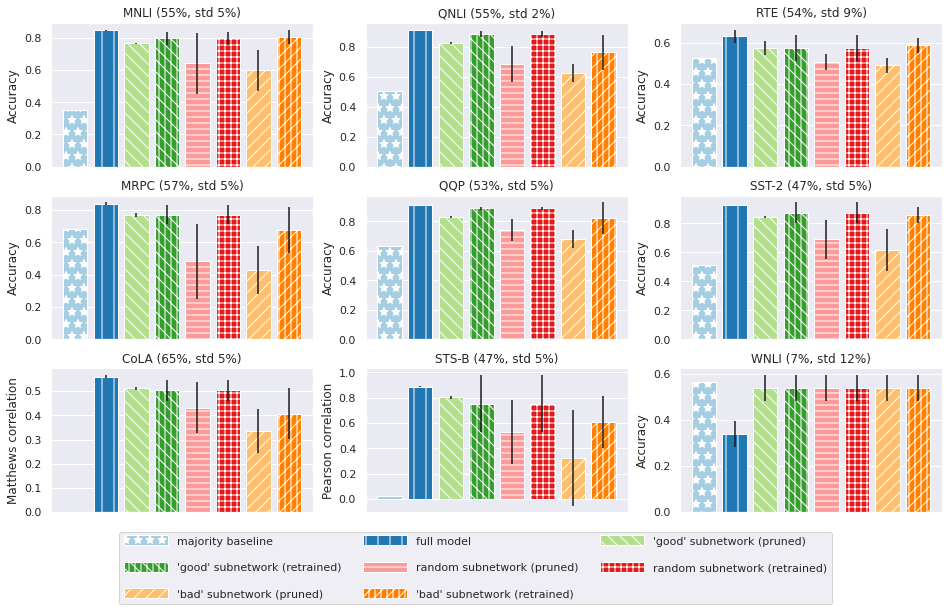

In [3]:
evaluation_dir = pathlib.Path("../evaluate_masked")


name_path = {
   
    "majority baseline": evaluation_dir / "freq_baseline" / "results.json",
    "full model": evaluation_dir / "no_mask" / "baseline" / "results.json",
    "'good' subnetwork (pruned)": evaluation_dir / "head_mlp" / "baseline" / "results.json",
    "'good' subnetwork (retrained)": evaluation_dir / "head_mlp_retrained" / "baseline" / "results.json",
    "random subnetwork (pruned)": evaluation_dir / "head_mlp_random" / "baseline" / "results.json",
    "random subnetwork (retrained)": evaluation_dir / "head_mlp_retrained" / "baseline" / "results.json",
    "'bad' subnetwork (pruned)": evaluation_dir / "head_mlp_bad_1" / "baseline" / "results.json",
    "'bad' subnetwork (retrained)": evaluation_dir / "head_mlp_bad_1_retrained" / "baseline" / "results.json",

    
#     "super survivor (pruned)": evaluation_dir / "head_mlp_super" / "baseline" / "results.json",
#     "super survivor (pruned, retrained)": evaluation_dir / "head_mlp_super_retrained" / "baseline" / "results.json",
#     "anti-survivor (pruned)": evaluation_dir / "head_mlp_super_bizzaro" / "baseline" / "results.json",
#     "anti-survivor (pruned, retrained)": evaluation_dir / "head_mlp_super_bizzaro_retrained" / "baseline" / "results.json",
#     "average-survivor (pruned)": evaluation_dir / "head_mlp_super_midling" / "baseline" / "results.json",
#     "average-survivor (pruned, retrained)": evaluation_dir / "head_mlp_super_midling_retrained" / "baseline" / "results.json",
}


analyzed_metrics = []
for name, path in name_path.items():
    with path.open() as f:
        metrics = json.load(f)
    analyzed_metrics.append((name, metrics))
plot_all_task_metrics(analyzed_metrics, "evaluation/importance_pruning_evaluation.pdf", importance_subnet_sizes)

/home/sai/miniconda3/envs/bertexp/lib/python3.7/site-packages/ipykernel_launcher.py:91: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


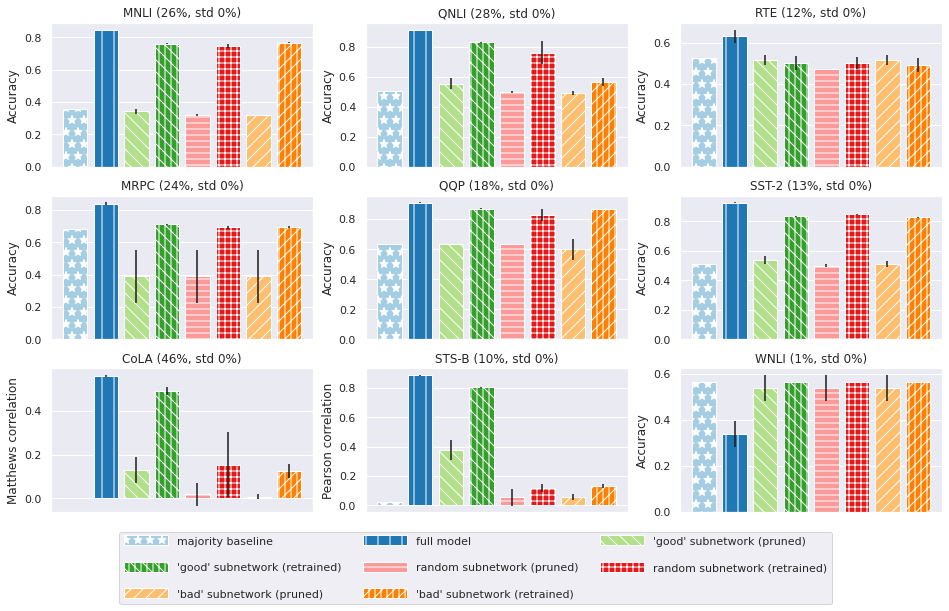

In [4]:
evaluation_dir = pathlib.Path("../evaluate_masked")
name_path = {


    "majority baseline": evaluation_dir / "freq_baseline" / "results.json",
    #"1 head mlp baseline  (retrained)": evaluation_dir / "head_mlp_zero_retrained" / "baseline" / "results.json",
    "full model": evaluation_dir / "no_mask" / "baseline" / "results.json",
    
    "'good' subnetwork (pruned)": evaluation_dir / "head_mlp_super" / "baseline" / "results.json",
    "'good' subnetwork (retrained)": evaluation_dir / "head_mlp_super_retrained" / "baseline" / "results.json",
    "random subnetwork (pruned)": evaluation_dir / "head_mlp_super_midling" / "baseline" / "results.json",
    "random subnetwork (retrained)": evaluation_dir / "head_mlp_super_midling_retrained" / "baseline" / "results.json",
    "'bad' subnetwork (pruned)": evaluation_dir / "head_mlp_super_bizzaro" / "baseline" / "results.json",
    "'bad' subnetwork (retrained)": evaluation_dir / "head_mlp_super_bizzaro_retrained" / "baseline" / "results.json",

    
#     "anti-survivor 2  (pruned)": evaluation_dir / "head_mlp_super_bizzaro_2" / "baseline" / "results.json",
#     "anti-survivor 2  (retrained)": evaluation_dir / "head_mlp_super_bizzaro_2_retrained" / "baseline" / "results.json",

#     "anti-survivor old (pruned)": evaluation_dir / "head_mlp_super_bad" / "baseline" / "results.json",
#     "anti-survivor old (retrained)": evaluation_dir / "head_mlp_super_bad_retrained" / "baseline" / "results.json",

}

analyzed_metrics = []
for name, path in name_path.items():
    with path.open() as f:
        metrics = json.load(f)
    analyzed_metrics.append((name, metrics))
plot_all_task_metrics(analyzed_metrics,  "evaluation/importance_pruning_super_evaluation.pdf", importance_subnet_super_sizes)

/home/sai/miniconda3/envs/bertexp/lib/python3.7/site-packages/ipykernel_launcher.py:91: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


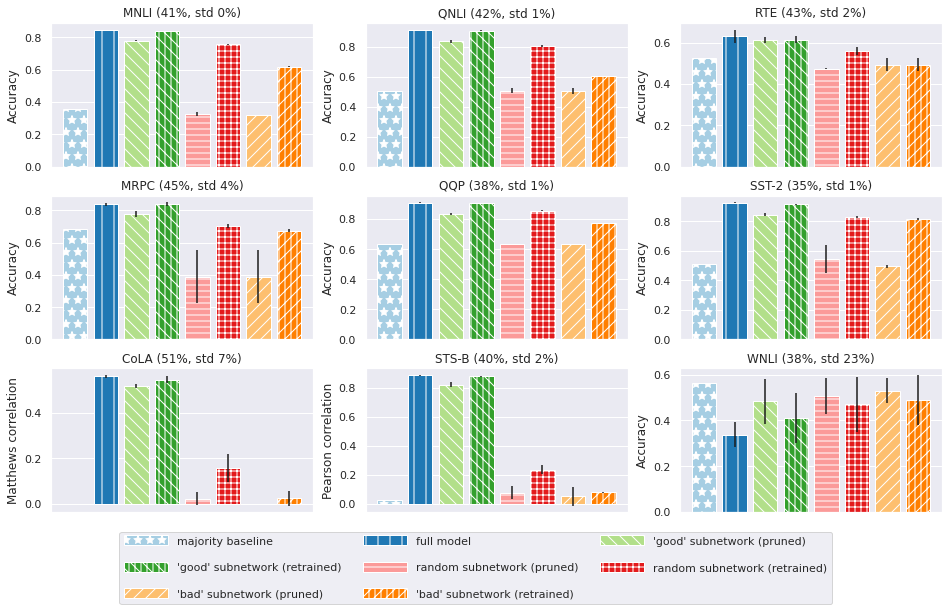

In [5]:
evaluation_dir = pathlib.Path("../evaluate_masked")
name_path = {
    "majority baseline": evaluation_dir / "freq_baseline" / "results.json",
    "full model": evaluation_dir / "no_mask" / "baseline" / "results.json",
    
    "'good' subnetwork (pruned)": evaluation_dir / "global_magnitude" / "baseline" / "results.json",
    "'good' subnetwork (retrained)": evaluation_dir / "global_magnitude_retrained" / "baseline" / "results.json",
    "random subnetwork (pruned)": evaluation_dir / "global_random" / "baseline" / "results.json",
    "random subnetwork (retrained)": evaluation_dir / "global_random_retrained" / "baseline" / "results.json",
    "'bad' subnetwork (pruned)": evaluation_dir / "global_bad" / "baseline" / "results.json",
    "'bad' subnetwork (retrained)": evaluation_dir / "global_bad_retrained" / "baseline" / "results.json",
#     "bad-mimic-pruned, retrained": evaluation_dir / "global_bad_mask_mimic_size" / "baseline" / "results.json",

#     "bad-mimic-pruned, retrained": evaluation_dir / "global_bad_mask_mimic_size_retrained" / "baseline" / "results.json",
#     "m-pruned mimic": evaluation_dir / "global_magnitude_mask_mimic_size" / "baseline" / "results.json",
#     "m-pruned mimic, retrained": evaluation_dir / "global_magnitude_mask_mimic_size_retrained" / "baseline" / "results.json",

#     "r-pruned, mimic": evaluation_dir / "global_random_mask_mimic_size" / "baseline" / "results.json",
#     "r-pruned mimic, retrained": evaluation_dir / "global_random_mask_mimic_size_retrained" / "baseline" / "results.json",
}


m_metrics = []
for name, path in name_path.items():
    with path.open() as f:
        metrics = json.load(f)
    m_metrics.append((name, metrics))
plot_all_task_metrics(m_metrics, "evaluation/magnitude_pruning_evaluation.pdf", magnitude_subnet_sizes)

In [6]:


def print_table(analyzed_metrics, horizontal_tasks=True):
    experiment_metrics = [(name, flatten_metrics(metrics)) for name, metrics in analyzed_metrics]

    if horizontal_tasks:
        tasks =  sorted(experiment_metrics[0][1].keys())
        tasks_metrics = [f"{task} {experiment_metrics[0][1][task]['metric']}" for task in tasks]
        table_md = f"|Experiment|{'|'.join(tasks)}|\n"
        table_md += f"|---|---|{'---|' * len(tasks)}\n"
        for experiment, metrics in experiment_metrics:

            mean_stds = [ f"{metrics[task]['mean']:.2f} *** {metrics[task]['stdv']:.2f}" for  task in tasks]
            table_md += f"|{experiment}|{'|'.join(mean_stds)}|\n"
        print(table_md)
    else:
        experiment_metrics = [(name, flatten_metrics(metrics)) for name, metrics in analyzed_metrics]
        table_md = ""
        experiments = [em[0] for em in experiment_metrics]
        table_md += f"|Task|Metric|{'|'.join(experiments)}|\n"
        table_md += f"|---|---|{'---|' * len(experiments)}\n"
        tasks =  sorted(experiment_metrics[0][1].keys())
        for task in tasks:
            mean_stds = [ f"{metrics[task]['mean']:.2f} ± {metrics[task]['stdv']:.2f}" for _, metrics in experiment_metrics]
            table_md += f"|{task}|{experiment_metrics[0][1][task]['metric']}|{'|'.join(mean_stds)}|\n"
        print(table_md)

In [7]:
evaluation_dir = pathlib.Path("../evaluate_masked")
name_path = {
   
    "majority baseline": evaluation_dir / "freq_baseline" / "results.json",
    "full model": evaluation_dir / "no_mask" / "baseline" / "results.json",
    
    "'good' subnetwork (pruned)": evaluation_dir / "head_mlp" / "baseline" / "results.json",
    "'good' subnetwork (retrained)": evaluation_dir / "head_mlp_retrained" / "baseline" / "results.json",
    "random subnetwork (pruned)": evaluation_dir / "head_mlp_random" / "baseline" / "results.json",
    "random subnetwork (retrained)": evaluation_dir / "head_mlp_random_retrained" / "baseline" / "results.json",
    "'bad' subnetwork (pruned)": evaluation_dir / "head_mlp_bad_1" / "baseline" / "results.json",
    "'bad' subnetwork (retrained)": evaluation_dir / "head_mlp_bad_1_retrained" / "baseline" / "results.json",
    
    "super 'good' subnetwork (pruned)": evaluation_dir / "head_mlp_super" / "baseline" / "results.json",
    "super 'good' subnetwork (retrained)": evaluation_dir / "head_mlp_super_retrained" / "baseline" / "results.json",
    "super random subnetwork (pruned)": evaluation_dir / "head_mlp_super_midling" / "baseline" / "results.json",
    "super random subnetwork (retrained)": evaluation_dir / "head_mlp_super_midling_retrained" / "baseline" / "results.json",
    "super 'bad' subnetwork (pruned)": evaluation_dir / "head_mlp_super_bizzaro" / "baseline" / "results.json",
    "super 'bad' subnetwork (retrained)": evaluation_dir / "head_mlp_super_bizzaro_retrained" / "baseline" / "results.json",
    
    "magnitude 'good' subnetwork (pruned)": evaluation_dir / "global_magnitude" / "baseline" / "results.json",
    "magnitude 'good' subnetwork (retrained)": evaluation_dir / "global_magnitude_retrained" / "baseline" / "results.json",
    "magnitude random subnetwork (pruned)": evaluation_dir / "global_random" / "baseline" / "results.json",
    "magnitude random subnetwork (retrained)": evaluation_dir / "global_random_retrained" / "baseline" / "results.json",
    "magnitude 'bad' subnetwork (pruned)": evaluation_dir / "global_bad" / "baseline" / "results.json",
    "magnitude 'bad' subnetwork (retrained)": evaluation_dir / "global_bad_retrained" / "baseline" / "results.json",
}


analyzed_metrics = []
for name, path in name_path.items():
    with path.open() as f:
        metrics = json.load(f)
    analyzed_metrics.append((name, metrics))
print_table(analyzed_metrics)

|Experiment|CoLA|MNLI|MRPC|QNLI|QQP|RTE|SST-2|STS-B|WNLI|
|---|---|---|---|---|---|---|---|---|---|---|
|majority baseline|0.00 *** 0.00|0.35 *** 0.00|0.68 *** 0.00|0.51 *** 0.00|0.63 *** 0.00|0.53 *** 0.00|0.51 *** 0.00|0.02 *** 0.00|0.56 *** 0.00|
|full model|0.56 *** 0.01|0.84 *** 0.00|0.84 *** 0.01|0.92 *** 0.00|0.91 *** 0.00|0.63 *** 0.03|0.93 *** 0.00|0.89 *** 0.00|0.34 *** 0.06|
|'good' subnetwork (pruned)|0.51 *** 0.01|0.76 *** 0.00|0.77 *** 0.01|0.83 *** 0.00|0.83 *** 0.01|0.57 *** 0.03|0.84 *** 0.01|0.80 *** 0.01|0.54 *** 0.06|
|'good' subnetwork (retrained)|0.50 *** 0.04|0.80 *** 0.04|0.77 *** 0.06|0.89 *** 0.02|0.89 *** 0.01|0.58 *** 0.06|0.87 *** 0.07|0.75 *** 0.23|0.54 *** 0.06|
|random subnetwork (pruned)|0.43 *** 0.11|0.64 *** 0.19|0.48 *** 0.23|0.69 *** 0.12|0.74 *** 0.07|0.51 *** 0.04|0.69 *** 0.13|0.53 *** 0.25|0.54 *** 0.06|
|random subnetwork (retrained)|0.42 *** 0.23|0.79 *** 0.08|0.68 *** 0.21|0.84 *** 0.05|0.88 *** 0.03|0.56 *** 0.05|0.89 *** 0.01|0.79 *** 0.08|